# Stitching overlapping images

You are given five overlapping images at this link: https://drive.google.com/drive/folders/1RRKGSiRIpYTK2KTNZxPMZHzf6Cwg-M-v?usp=share_link

You are supposed to stitch all images given above and generate a final image which looks like this: https://drive.google.com/file/d/1igoXko7qtae5RxxB_ddpY7TKVaX2vc1d/view?usp=sharing

In [1]:
!gdown -q --folder https://drive.google.com/drive/folders/1RRKGSiRIpYTK2KTNZxPMZHzf6Cwg-M-v
!gdown -q  1igoXko7qtae5RxxB_ddpY7TKVaX2vc1d

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import least_squares
import pandas as pd
import os

# 1. Arrange pictures such that adjacent pictures have atleast 40% overlap. Order the pictures from left to right.

In [3]:
image_filenames = [os.path.join("overlapping-images", file) for file in sorted(os.listdir("overlapping-images"))]
images = []

for filename in image_filenames:
    img = cv2.imread(filename)
    images.append(img)

print(f"Loaded {len(images)} images")

Loaded 5 images


# Helper Functions

I took references from the following sources for these helper function:

1. https://github.com/real-ojaswi/create-panorama/blob/main/create_panorama.py
2. https://github.com/aartighatkesar/Image-Mosaicing/tree/master

In [4]:
def compute_homography(src_pts, dst_pts):
    """Compute homography matrix from point correspondences."""
    num_points = src_pts.shape[0]
    A = np.zeros((2 * num_points, 8), dtype=np.float64)
    B = np.zeros((2 * num_points, 1), dtype=np.float64)

    for i in range(num_points):
        x_src, y_src = src_pts[i]
        x_dst, y_dst = dst_pts[i]

        A[2 * i] = [x_src, y_src, 1, 0, 0, 0, -x_dst * x_src, -x_dst * y_src]
        B[2 * i] = x_dst

        A[2 * i + 1] = [0, 0, 0, x_src, y_src, 1, -y_dst * x_src, -y_dst * y_src]
        B[2 * i + 1] = y_dst

    h = np.linalg.lstsq(A, B, rcond=None)[0]
    H = np.append(h, 1).reshape(3, 3)

    return H


def ransac_homography(src_pts, dst_pts, epsilon=0.3, sigma=1.5):
    """Apply RANSAC to find robust homography and inliers."""
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)

    threshold = 20 * sigma
    num_points = src_pts.shape[0]

    P = 0.999
    num_iterations = int(np.ceil(np.log(1 - P) / np.log(1 - (1 - epsilon) ** 4)))
    print(f'  RANSAC iterations: {num_iterations}')

    max_inliers = 0
    best_H = None
    best_inliers = np.zeros(num_points, dtype=bool)
    src_pts_homogeneous = np.hstack((src_pts, np.ones((num_points, 1))))

    for iteration in range(num_iterations):
        sample_indices = np.random.choice(num_points, size=4, replace=False)
        src_sample = src_pts[sample_indices]
        dst_sample = dst_pts[sample_indices]

        H = compute_homography(src_sample, dst_sample)

        dst_pts_pred = np.dot(H, src_pts_homogeneous.T).T
        dst_pts_pred[:, :-1] /= dst_pts_pred[:, -1:]

        distances = np.linalg.norm(dst_pts_pred[:, :-1] - dst_pts, axis=1)

        inliers = distances < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers
            if max_inliers > 0.9 * num_points:
                print(f'  Early stopping at iteration {iteration} with {max_inliers}/{num_points} inliers')
                break

    print(f'  Final inliers: {max_inliers}/{num_points} ({100*max_inliers/num_points:.1f}%)')

    if np.any(best_inliers):
        inlier_src_pts = src_pts[best_inliers]
        inlier_dst_pts = dst_pts[best_inliers]
        best_H = compute_homography(inlier_src_pts, inlier_dst_pts)

    return best_H, best_inliers


def reprojection_error(h, src_pts, dst_pts):
    """Compute reprojection error for homography refinement."""
    H = np.array([
        [h[0], h[1], h[2]],
        [h[3], h[4], h[5]],
        [h[6], h[7], 1.0]
    ])

    src_pts_h = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
    projected_pts_h = (H @ src_pts_h.T).T
    projected_pts = projected_pts_h[:, :2] / projected_pts_h[:, 2:3]
    error = dst_pts[:, :2] - projected_pts

    return error.flatten()


def refine_homography_lm(src_pts, dst_pts, initial_H):
    """Refine homography using Levenberg-Marquardt optimization."""
    h0 = initial_H.flatten()[:8]
    result = least_squares(reprojection_error, h0, args=(src_pts, dst_pts))
    h_optimized = result.x
    refined_H = np.array([
        [h_optimized[0], h_optimized[1], h_optimized[2]],
        [h_optimized[3], h_optimized[4], h_optimized[5]],
        [h_optimized[6], h_optimized[7], 1.0]
    ])

    return refined_H


def create_panorama(images, homographies):
    """Projects images onto a blank canvas to create a panorama."""
    min_x, min_y, max_x, max_y = 0, 0, 0, 0

    for i, img in enumerate(images):
        if homographies[i] is not None:
            h, w = img.shape[:2]
            corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32).reshape(-1, 1, 2)
            transformed_corners = cv2.perspectiveTransform(corners, homographies[i])

            min_x = min(min_x, np.min(transformed_corners[:, 0, 0]))
            min_y = min(min_y, np.min(transformed_corners[:, 0, 1]))
            max_x = max(max_x, np.max(transformed_corners[:, 0, 0]))
            max_y = max(max_y, np.max(transformed_corners[:, 0, 1]))

    canvas_width = int(max_x - min_x)
    canvas_height = int(max_y - min_y)
    offset_x = -min_x
    offset_y = -min_y

    panorama = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    for i, img in enumerate(images):
        if homographies[i] is not None:
            translation_matrix = np.array([[1, 0, offset_x],
                                           [0, 1, offset_y],
                                           [0, 0, 1]], dtype=np.float64)

            full_homography = translation_matrix @ homographies[i]
            warped_image = cv2.warpPerspective(img, full_homography, (canvas_width, canvas_height), flags=cv2.INTER_LINEAR)

            mask = (warped_image > 0).astype(np.uint8)
            panorama = panorama * (1 - mask) + warped_image * mask

    return panorama


# 2. Generate SIFT features among images

In [5]:
sift = cv2.SIFT_create(nfeatures=500)
keypoints = []
descriptors = []

for img in images:
    kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), None)
    keypoints.append(kp)
    descriptors.append(des)

# 3. Establish correspondence between features

In [6]:
bf = cv2.BFMatcher(cv2.NORM_L2)
all_matches = []

for i in range(len(descriptors) - 1):
    matches = bf.knnMatch(descriptors[i], descriptors[i+1], k=2)
    all_matches.append(matches)

good_matches_list = []
all_img1_kp = []
all_img2_kp = []

ratio = 0.75

for i, matches in enumerate(all_matches):
    good_matches = []
    img1_kp = []
    img2_kp = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
            img1_kp.append(keypoints[i][m.queryIdx].pt)
            img2_kp.append(keypoints[i+1][m.trainIdx].pt)

    good_matches_list.append(good_matches)
    all_img1_kp.append(np.array(img1_kp))
    all_img2_kp.append(np.array(img2_kp))

# 4. Apply RANSAC (Random Sampling and Consensus) to get rid of outliers
# 5. Generate initial estimate of Homography using inlier correspondence points obtained in step 4 (RANSAC step)

In [7]:
homographies = []
inliers_list = []

for i in range(len(all_img1_kp)):
    print(f"\nProcessing image pair {i} -> {i+1}")
    if len(all_img1_kp[i]) >= 4:
        H, inliers = ransac_homography(all_img1_kp[i], all_img2_kp[i])
        homographies.append(H)
        inliers_list.append(inliers)
    else:
        print(f"  Not enough matches for pair {i} -> {i+1}")
        homographies.append(None)
        inliers_list.append(None)


Processing image pair 0 -> 1
  RANSAC iterations: 26
  Final inliers: 117/137 (85.4%)

Processing image pair 1 -> 2
  RANSAC iterations: 26
  Final inliers: 85/119 (71.4%)

Processing image pair 2 -> 3
  RANSAC iterations: 26
  Final inliers: 188/246 (76.4%)

Processing image pair 3 -> 4
  RANSAC iterations: 26
  Final inliers: 179/234 (76.5%)


# 6. Refine the Homography estimate using Levenberg - Marquardt optimization

In [8]:
refined_homographies = []

for i in range(len(homographies)):
    initial_H = homographies[i]
    if initial_H is not None and inliers_list[i] is not None:
        src_pts_inliers = all_img1_kp[i][inliers_list[i]]
        dst_pts_inliers = all_img2_kp[i][inliers_list[i]]
        refined_H = refine_homography_lm(src_pts_inliers, dst_pts_inliers, initial_H)
        refined_homographies.append(refined_H)
    else:
        refined_homographies.append(None)

# 7. Repeat the above steps for each of the adjacent image pairs
# 8. After obtaining Homographies for each of the picture pairs, get the homographies with respect to the central image

In [9]:
center_index = len(images) // 2
central_homographies = [None] * len(images)
central_homographies[center_index] = np.eye(3)

# Propagate to the right
for i in range(center_index, len(refined_homographies)):
    if refined_homographies[i] is not None and central_homographies[i] is not None:
        central_homographies[i+1] = central_homographies[i] @ np.linalg.inv(refined_homographies[i])

# Propagate to the left
for i in range(center_index, 0, -1):
    if refined_homographies[i-1] is not None and central_homographies[i] is not None:
        central_homographies[i-1] = central_homographies[i] @ refined_homographies[i-1]

# 9. Project all images (using inverse warping) on to a blank canvas. Use bilinear interpolation

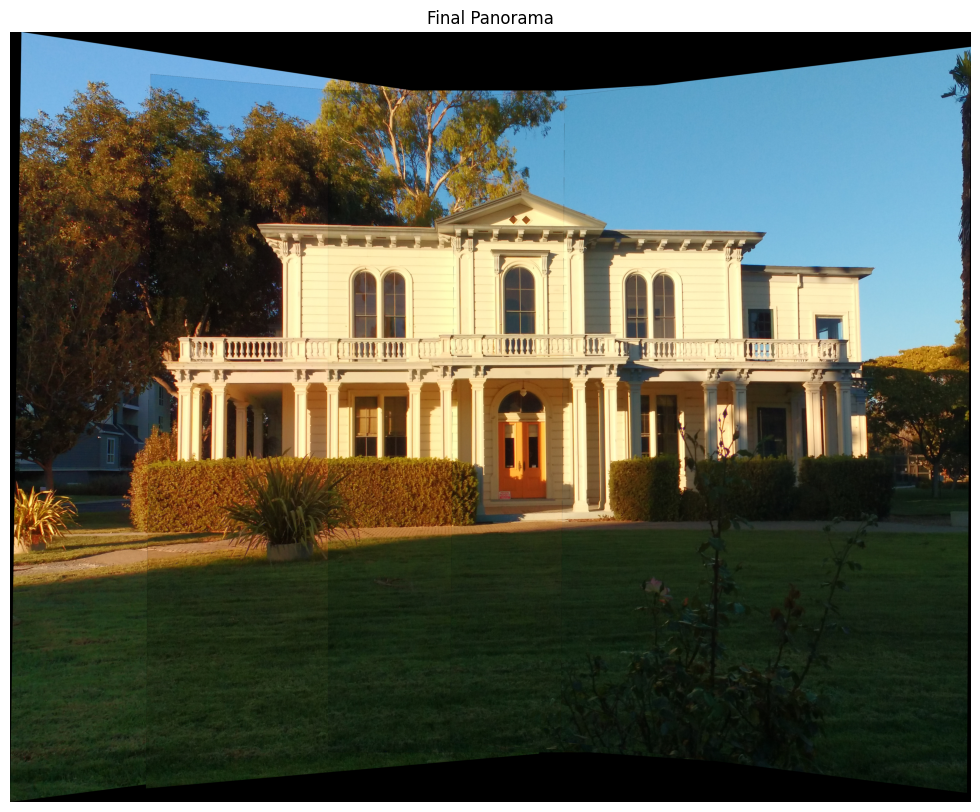

In [10]:
final_panorama = create_panorama(images, central_homographies)
cv2.imwrite("final_panorama.jpg", final_panorama)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(final_panorama, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama")
plt.axis('off')
plt.show()

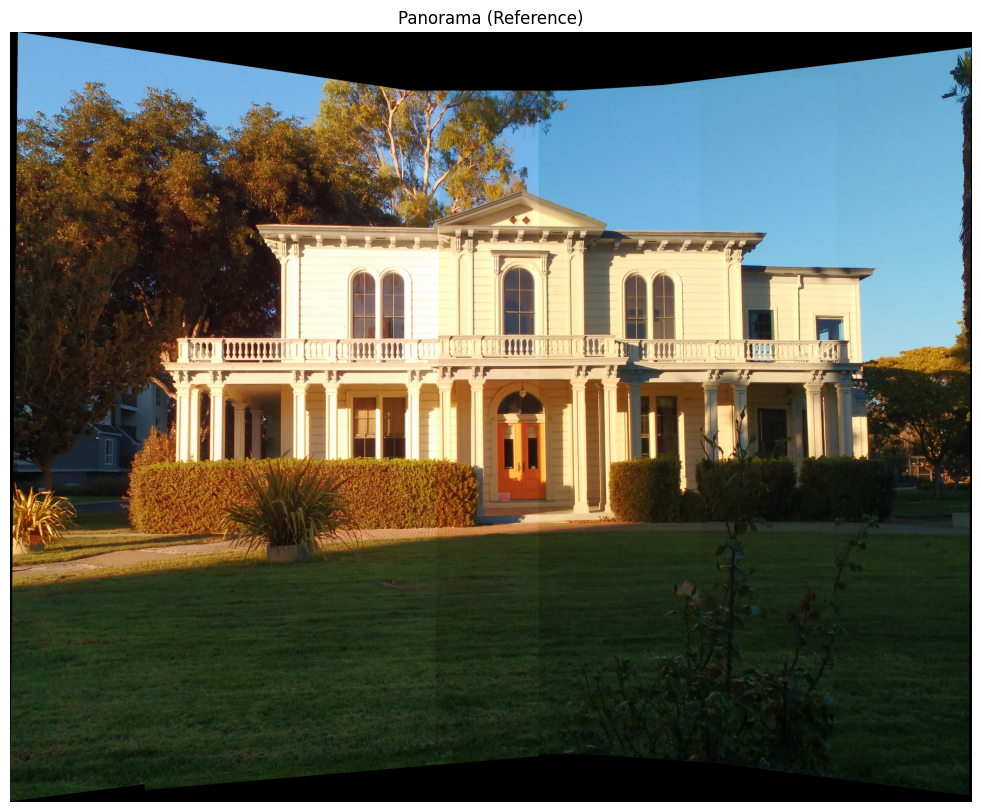

In [11]:
plt.figure(figsize=(20, 10))
reference_image = cv2.imread("final.jpg")
plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
plt.title("Panorama (Reference)")
plt.axis('off')
plt.show()